# Understanding Transfer Learning - part 1

Author: YinTaiChen

In [1]:
%matplotlib inline

In [2]:
import torchvision
from torchvision import transforms

import torch
import torch.nn as nn
import torch.optim as optim


from load_data import ImageFilelist

import matplotlib.pyplot as plt
import numpy as np

In [3]:
model = torchvision.models.alexnet(pretrained=True)

## Understanding the input size of Alexnet

In [4]:
print(model)

AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (9216 -> 4096)
    (2): ReLU (inplace)
    (3): Dropout (p = 0.5)
    (4): Linear (4096 -> 4096)
    (5): ReLU (inplace)
    (6): Linear (4096 -> 1000)
  )
)


(1): Linear (9216 -> 4096)
(10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [5]:
input_size = 9216/256
print(input_size)

36.0


In [6]:
input_size **= 0.5
print(input_size)

6.0


(12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))

In [7]:
input_size = (input_size - 1) * 2 + 3
print(input_size)

13.0


(10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [8]:
input_size += (-1+3-2*1)
print(input_size)

13.0


(8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [9]:
input_size += (-1+3-2*1)
print(input_size)

13.0


(6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [10]:
input_size += (-1+3-2*1)
print(input_size)

13.0


(5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))

In [11]:
input_size = (input_size - 1) * 2 + 3
print(input_size)

27.0


(3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

In [12]:
input_size += (-1+5-2*2)
print(input_size)

27.0


(2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))

In [13]:
input_size = (input_size - 1) * 2 + 3
print(input_size)

55.0


(0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

In [14]:
input_size = (input_size - 1) * 4 + 11 - 2*2
print(input_size)

223.0


## Load dataset according to the input size

Reference: https://github.com/YinTaiChen/Understanding-PyTorch-in-Depth/blob/master/Dataset%20Loading.ipynb

In [15]:
transform = transforms.Compose(
    [transforms.Scale(size=(223,223)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [16]:
trainset = ImageFilelist(root="./train", flist="dataset.txt", transform=transform)

In [17]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=3, shuffle=True, num_workers=3)

In [18]:
dataiter = iter(trainloader)

In [19]:
images, labels = dataiter.next()

In [20]:
type(images), type(labels)

(torch.FloatTensor, torch.LongTensor)

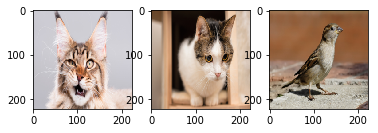

In [21]:
for i in range(3):
    image = images[i]
    image = image / 2 + 0.5
    np_array = image.numpy()
    plt.subplot(131+i)
    plt.imshow(np.transpose(np_array, (1,2,0)))

In [22]:
for i in range(3):
    print(labels[i])

2
2
0


## Try to implement Transfer Learning

Reference: http://pytorch.org/docs/0.2.0/_modules/torchvision/models/alexnet.html

In [23]:
model.features

Sequential (
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU (inplace)
  (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU (inplace)
  (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU (inplace)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU (inplace)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU (inplace)
  (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
)

In [24]:
model.classifier

Sequential (
  (0): Dropout (p = 0.5)
  (1): Linear (9216 -> 4096)
  (2): ReLU (inplace)
  (3): Dropout (p = 0.5)
  (4): Linear (4096 -> 4096)
  (5): ReLU (inplace)
  (6): Linear (4096 -> 1000)
)

In [25]:
model.classifier[6]

Linear (4096 -> 1000)

In [26]:
model.classifier[6] = nn.Linear(4096, 3)

TypeError: 'Sequential' object does not support item assignment

## OMG! What do I do?

Answer: 